In [5]:
import urllib
import json
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from keys import client_id, client_secret, app_id

In [9]:
data = pd.read_csv('COVID-19 Cases - COVID-19 Cases.csv')

In [10]:
states = data['Province_State'].unique().tolist()
dates = data['Date'].unique().tolist()
coords = data.groupby(['Lat', 'Long']).size().index.tolist()
data['avg_tmp'] = np.nan
data['avg_RH'] = np.nan
data['avg_wind'] = np.nan
data['avg_precip'] = np.nan
# data['avg_d_sun'] = np.nan
data['avg_m_tmp'] = np.nan
data['avg_m_RH'] = np.nan
data['avg_m_wind'] = np.nan
data['avg_m_precip'] = np.nan

In [11]:
START_TIME = '02/14/2020'
END_TIME = '02/24/2020'
RADIUS = 350
q = 0
log = open('log{0}'.format(datetime.now().strftime('%d%m%Y')), 'w')
for coord in coords:
    q += 1
    lat = coord[0]
    long = coord[1]
    location = data.loc[data['Lat'] == lat]\
                    .loc[data['Long'] == long]\
                     [['Country_Region','Province_State']]
    country = location.iloc[0][0]
    province = location.iloc[0][1]
    url = 'https://api.aerisapi.com/observations/summary/closest?p={0},{1}&from={2}&to={3}&radius={4}miles&plimit=31&limit=1&'\
          'client_id={5}&client_secret={6}'.format(lat, long, START_TIME, END_TIME, RADIUS, client_id, client_secret)
    print('collecting for {0} location {1}, {2}\n{3}'.format(q, province, country, url))
    request = urllib.request.urlopen(url)
    response = request.read()
    json_ = json.loads(response)
    if json_['success']: 
        print('success')
        try:
            for day in json_['response'][0]['periods']:
                date = datetime.strptime(str(day['summary']['ymd']), '%Y%m%d').strftime("%-m/%-d/%Y")
                for index in data.loc[data['Date'] == date]\
                                 .loc[data['Lat'] == coord[0]]\
                                 .loc[data['Long'] == coord[1]].index:
                    data.at[index, 'avg_d_tmp'] = day['summary']['temp']['avgC']
                    data.at[index, 'avg_d_RH'] = day['summary']['rh']['avg']
                    data.at[index, 'avg_d_wind'] = day['summary']['wind']['avgKPH']
                    data.at[index, 'avg_d_precip'] = day['summary']['precip']['totalMM']
#                     data.at[index, 'avg_d_sun'] = day['summary']['solrad']['avgWM2']                    
        except IndexError:
            if json_['error']:
                msg = 'No data found for {0}, {1} at {2}\n{3}\r\n'.format(country, province, date, json_['error'])
                print(msg)
                log.write(msg)
        except Exception:
            msg = 'Unknowen error\n{0}\r\n'.format(json_['error'])
            print(msg)
            log.write(msg)
        finally:
            request.close()
log.close()

collecting for 1 location Tasmania, Australia
https://api.aerisapi.com/observations/summary/closest?p=-41.4545,145.9707&from=02/14/2020&to=02/24/2020&radius=350miles&plimit=31&limit=1&client_id=vv2IYjrS6kv2D52249jl9&client_secret=ZbwMRSbTTYKsqBsQRkYyoquHjq2Enr1gkaXHxC33
success
collecting for 2 location nan, New Zealand
https://api.aerisapi.com/observations/summary/closest?p=-40.9006,174.886&from=02/14/2020&to=02/24/2020&radius=350miles&plimit=31&limit=1&client_id=vv2IYjrS6kv2D52249jl9&client_secret=ZbwMRSbTTYKsqBsQRkYyoquHjq2Enr1gkaXHxC33
success
collecting for 3 location nan, Argentina
https://api.aerisapi.com/observations/summary/closest?p=-38.4161,-63.6167&from=02/14/2020&to=02/24/2020&radius=350miles&plimit=31&limit=1&client_id=vv2IYjrS6kv2D52249jl9&client_secret=ZbwMRSbTTYKsqBsQRkYyoquHjq2Enr1gkaXHxC33
success
collecting for 4 location Victoria, Australia
https://api.aerisapi.com/observations/summary/closest?p=-37.8136,144.9631&from=02/14/2020&to=02/24/2020&radius=350miles&plimit

KeyboardInterrupt: 

In [961]:
############################
# HANDLE NaN AND SAVE DATA #
############################

# data = backup.copy()
data[['Province_State']] = data[['Province_State']].fillna(0)
data = data.drop('avg_sun', axis=1)
data = data.dropna()

In [962]:
##############################################
# COMPUTE AVG PARAMETERS FOR CONFIRMED CASES #
##############################################

conf_data = data[data['Case_Type'] == 'Confirmed']
death_data = data[data['Case_Type'] == 'Deaths']
for coord in coords:
    lat = coord[0]
    long = coord[1]
    indices = conf_data.loc[conf_data['Lat'] == lat].loc[conf_data['Long'] == long].index.tolist()
    avg_tmp = conf_data.loc[conf_data['Lat'] == lat]\
                       .loc[conf_data['Long'] == long]['avg_tmp'].mean()
    
    avg_rh = conf_data.loc[conf_data['Lat'] == lat]\
                   .loc[conf_data['Long'] == long]['avg_RH'].mean()
    
    avg_wind = conf_data.loc[conf_data['Lat'] == lat]\
                   .loc[conf_data['Long'] == long]['avg_wind'].mean()
    
    avg_precip = conf_data.loc[conf_data['Lat'] == lat]\
                   .loc[conf_data['Long'] == long]['avg_precip'].mean()                             
    
    for index in indices:
        conf_data.at[index, 'avg_m_tmp'] = avg_tmp
        conf_data.at[index, 'avg_m_RH'] = avg_rh
        conf_data.at[index, 'avg_m_wind'] = avg_wind
        conf_data.at[index, 'avg_m_precip'] = avg_precip                            

In [963]:
###########################################
# COMPUTE AVG PARAMETERS FOR DEATHS CASES #
###########################################

for coord in coords:
    lat = coord[0]
    long = coord[1]
    indices = death_data.loc[data['Lat'] == lat].loc[death_data['Long'] == long].index.tolist()
    avg_tmp = death_data.loc[death_data['Lat'] == lat]\
                       .loc[death_data['Long'] == long]['avg_tmp'].mean()
    
    avg_rh = death_data.loc[death_data['Lat'] == lat]\
                   .loc[death_data['Long'] == long]['avg_RH'].mean()
    
    avg_wind = death_data.loc[death_data['Lat'] == lat]\
                   .loc[death_data['Long'] == long]['avg_wind'].mean()
    
    avg_precip = death_data.loc[death_data['Lat'] == lat]\
                   .loc[death_data['Long'] == long]['avg_precip'].mean()                             
    
    for index in indices:
        death_data.at[index, 'avg_m_tmp'] = avg_tmp
        death_data.at[index, 'avg_m_RH'] = avg_rh
        death_data.at[index, 'avg_m_wind'] = avg_wind
        death_data.at[index, 'avg_m_precip'] = avg_precip                            

In [23]:
conf_data = pd.read_csv('conf_data.csv')
death_data = pd.read_csv('death_data.csv')

In [24]:
#####################################################################
# COMPUTE GROWTH-FACTOR AND MAX CASES, MAX DATE FOR CONFIRMED CASES #
#####################################################################

conf_data['max_date'] = ''
conf_data['growth_factor'] = np.nan
conf_data['max_cases'] = np.nan
for coord in coords:
    lat = coord[0]
    long = coord[1]
    max_cases = conf_data.loc[conf_data['Lat'] == lat]\
                         .loc[conf_data['Long'] == long]['Cases'].max()
    max_date = conf_data.loc[conf_data['Lat'] == lat]\
                        .loc[conf_data['Long'] == long][conf_data['Cases'] == max_cases]['Date']
    
    max_date_parsed = datetime.strptime('3/8/2020', '%m/%d/%Y')
    four_days = max_date_parsed - timedelta(days = 4)
    four_days = four_days.strftime('%-m/%-d/%Y')
    
    try:
        four_days_cases = conf_data.loc[conf_data['Lat'] == lat]\
                         .loc[conf_data['Long'] == long]\
                         .loc[conf_data['Date'] == four_days]['Cases'].values[0]
    except IndexError:
        four_days_cases = max_cases
        
    rate = max_cases / four_days_cases 
    growth_factor = rate**0.25
    
    indices = conf_data.loc[conf_data['Lat'] == lat]\
                        .loc[conf_data['Long'] == long].index.tolist()
    for index in indices:
        conf_data.at[index, 'max_date'] = max_date.values[0] 
        conf_data.at[index, 'growth_factor'] = growth_factor
        conf_data.at[index, 'max_cases'] = max_cases

/Users/nirweingarten/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/nirweingarten/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


In [20]:
##################################################################
# COMPUTE GROWTH-FACTOR AND MAX CASES, MAX DATE FOR DEATH CASES #
##################################################################

death_data['max_date'] = ''
death_data['growth_factor'] = np.nan
death_data['max_cases'] = np.nan
for coord in coords:
    lat = coord[0]
    long = coord[1]
    max_cases = death_data.loc[death_data['Lat'] == lat]\
                         .loc[death_data['Long'] == long]['Cases'].max()
    max_date = death_data.loc[death_data['Lat'] == lat]\
                        .loc[death_data['Long'] == long][death_data['Cases'] == max_cases]['Date']
    
    max_date_parsed = datetime.strptime('3/8/2020', '%m/%d/%Y')
    four_days = max_date_parsed - timedelta(days = 4)
    four_days = four_days.strftime('%-m/%-d/%Y')
    
    try:
        four_days_cases = death_data.loc[death_data['Lat'] == lat]\
                         .loc[death_data['Long'] == long]\
                         .loc[death_data['Date'] == four_days]['Cases'].values[0]
    except IndexError:
        four_days_cases = max_cases
        
    rate = max_cases / four_days_cases 
    growth_factor = rate**0.25
    
    indices = death_data.loc[death_data['Lat'] == lat]\
                        .loc[death_data['Long'] == long].index.tolist()
    for index in indices:
        death_data.at[index, 'max_date'] = max_date.values[0] 
        death_data.at[index, 'growth_factor'] = growth_factor
        death_data.at[index, 'max_cases'] = max_cases

/Users/nirweingarten/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/nirweingarten/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/Users/nirweingarten/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in long_scalars


In [22]:
death_data

,Unnamed: 0,Date,Country_Region,Province_State,Case_Type,Cases,Difference,Prep_Flow_Runtime,Latest_Date,Lat,...,avg_RH,avg_wind,avg_precip,avg_m_tmp,avg_m_RH,avg_m_wind,avg_m_precip,max_date,growth_factor,max_cases
0,1,3/11/2020,US,Arizona,Deaths,0,0,3/23/2020 8:00:09 AM,3/22/2020,32.0575,...,75.0,6.6,0.25,14.913158,48.078947,8.573684,0.681579,3/11/2020,NaN,0.0
1,5,2/15/2020,US,Arizona,Deaths,0,0,3/23/2020 8:00:09 AM,3/22/2020,32.8162,...,47.0,1.7,0.00,14.913158,48.078947,8.573684,0.681579,2/15/2020,NaN,0.0
2,13,3/17/2020,US,Arizona,Deaths,0,0,3/23/2020 8:00:09 AM,3/22/2020,32.0575,...,42.0,7.7,0.00,14.913158,48.078947,8.573684,0.681579,3/11/2020,NaN,0.0
3,17,3/3/2020,US,Arizona,Deaths,0,0,3/23/2020 8:00:09 AM,3/22/2020,33.2918,...,51.0,13.8,0.00,15.981579,55.736842,8.336842,1.570526,3/3/2020,NaN,0.0
4,25,3/17/2020,US,Arizona,Deaths,0,0,3/23/2020 8:00:09 AM,3/22/2020,33.2918,...,53.0,9.8,0.00,15.981579,55.736842,8.336842,1.570526,3/3/2020,NaN,0.0
5,29,2/25/2020,US,Arizona,Deaths,0,0,3/23/2020 8:00:09 AM,3/22/2020,32.8162,...,48.0,12.8,0.00,14.913158,48.078947,8.573684,0.681579,2/15/2020,NaN,0.0
6,37,3/1/2020,US,Arizona,Deaths,0,0,3/23/2020 8:00:09 AM,3/22/2020,33.2918,...,50.0,10.6,0.00,15.981579,55.736842,8.336842,1.570526,3/3/2020,NaN,0.0
7,45,3/10/2020,US,Arizona,Deaths,0,0,3/23/2020 8:00:09 AM,3/22/2020,32.0575,...,50.0,7.2,2.03,14.913158,48.078947,8.573684,0.681579,3/11/2020,NaN,0.0
8,49,2/16/2020,US,Arizona,Deaths,0,0,3/23/2020 8:00:09 AM,3/22/2020,32.0575,...,43.0,3.0,0.00,14.913158,48.078947,8.573684,0.681579,3/11/2020,NaN,0.0
9,53,3/4/2020,US,Arizona,Deaths,0,0,3/23/2020 8:00:09 AM,3/22/2020,33.2918,...,56.0,7.3,0.00,15.981579,55.736842,8.336842,1.570526,3/3/2020,NaN,0.0


In [972]:
######################
# SAVE COMPUTED DATA #
######################

conf_data.to_csv('conf_data.csv')
death_data.to_csv('death_data.csv')


Death cases max_cases correaltion Pearson
Cases            0.999995
Difference       0.855093
growth_factor    0.821659
avg_wind         0.073592
Long             0.062536
Lat              0.061170
avg_RH           0.028359
avg_tmp          0.000887
avg_m_RH        -0.015177
avg_m_tmp       -0.016858
avg_precip      -0.032204
avg_m_wind      -0.054194
avg_m_precip    -0.058316
dtype: float64

Death cases max_cases correaltion Spearman
Cases           0.916256
Difference      0.572851
Lat             0.205643
Long            0.068733
avg_m_RH        0.066074
avg_precip     -0.025254
avg_m_wind     -0.047246
avg_wind       -0.053773
avg_RH         -0.075220
avg_m_precip   -0.089167
avg_tmp        -0.162024
avg_m_tmp      -0.177442
dtype: float64

Confirmed cases max_cases correaltion Pearson
Cases            0.999954
Difference       0.696918
growth_factor    0.679459
Long             0.104040
Lat              0.075724
avg_wind         0.029156
avg_m_RH         0.009652
avg_RH          

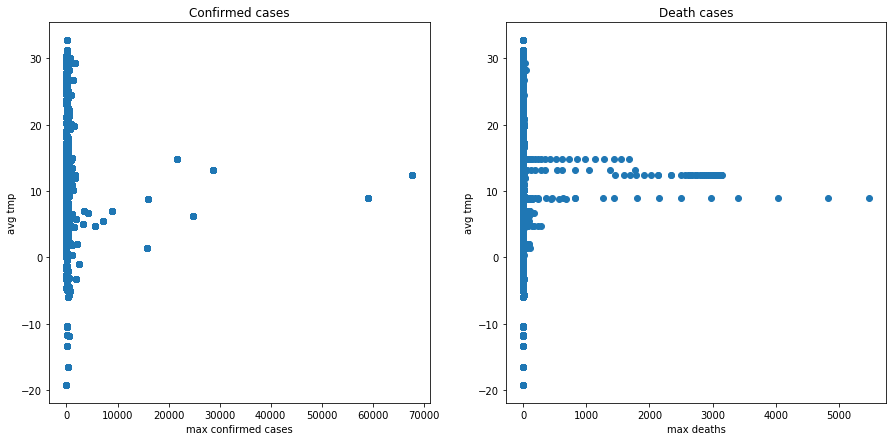

In [966]:
############################################################################
# CORRELATIONS AND SCATTER PLOTS AVG TMP VS MAX CASES CONFIRMED AND DEATHS #
############################################################################

TMP_RATE = 1
deaths = death_data[death_data['Date'] == '3/22/2020'][death_data['max_cases'].astype(int) > 0]
confs = conf_data[conf_data['Date'] == '3/22/2020'][conf_data['max_cases'].astype(int) > 0]

deaths['avg_m_tmp'] = deaths['avg_m_tmp'] * TMP_RATE
confs['avg_m_tmp'] = confs['avg_m_tmp'] * TMP_RATE

death_corrs = deaths.corr().unstack().sort_values(kind="quicksort", ascending=False)
death_corrs = death_corrs[death_corrs != 1]
_ = death_corrs.drop_duplicates()
print('\nDeath cases max_cases correaltion Pearson')
print(death_corrs['max_cases'])

death_corrs = deaths.corr('spearman').unstack().sort_values(kind="quicksort", ascending=False)
death_corrs = death_corrs[death_corrs != 1]
_ = death_corrs.drop_duplicates()
print('\nDeath cases max_cases correaltion Spearman')
print(death_corrs['max_cases'])

conf_corrs = confs.corr().unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs = conf_corrs[conf_corrs != 1]
_ = conf_corrs.drop_duplicates()
print('\nConfirmed cases max_cases correaltion Pearson')
print(conf_corrs['max_cases'])

conf_corrs = confs.corr('spearman').unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs = conf_corrs[conf_corrs != 1]
_ = conf_corrs.drop_duplicates()
print('\nConfirmed cases max_cases correaltion Spearman')
print(conf_corrs['max_cases'])

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
_ = axes[0].scatter(conf_data['max_cases'], conf_data['avg_m_tmp'])
_ = axes[1].scatter(death_data['Cases'], death_data['avg_m_tmp'])
_ = axes[0].set_xlabel('max confirmed cases')
_ = axes[0].set_ylabel('avg tmp')
_ = axes[0].set_title('Confirmed cases')
_ = axes[1].set_xlabel('max deaths')
_ = axes[1].set_ylabel('avg tmp')
_ = axes[1].set_title('Death cases')


Confirmed cases growth_rate correaltion Pearson
max_cases       0.725467
Cases           0.725166
Difference      0.653597
Lat             0.293268
Long            0.074156
avg_m_precip    0.034229
avg_precip      0.032194
avg_m_RH        0.029353
avg_RH         -0.039888
avg_wind       -0.047577
avg_m_wind     -0.090362
avg_tmp        -0.253671
avg_m_tmp      -0.260450
dtype: float64

Confirmed cases growth_rate correaltion Spearman
Cases           0.993572
Difference      0.708253
Lat             0.341079
avg_precip      0.053877
Long            0.050958
avg_m_precip    0.043987
avg_m_RH       -0.033968
avg_wind       -0.067642
avg_m_wind     -0.076968
avg_RH         -0.097490
avg_tmp        -0.335001
avg_m_tmp      -0.358204
dtype: float64

Death cases growth_rate correaltion Pearson
max_cases       0.821659
Cases           0.821578
Difference      0.723710
Lat             0.153972
Long            0.081531
avg_m_RH        0.022106
avg_wind        0.016370
avg_RH          0.006595
a

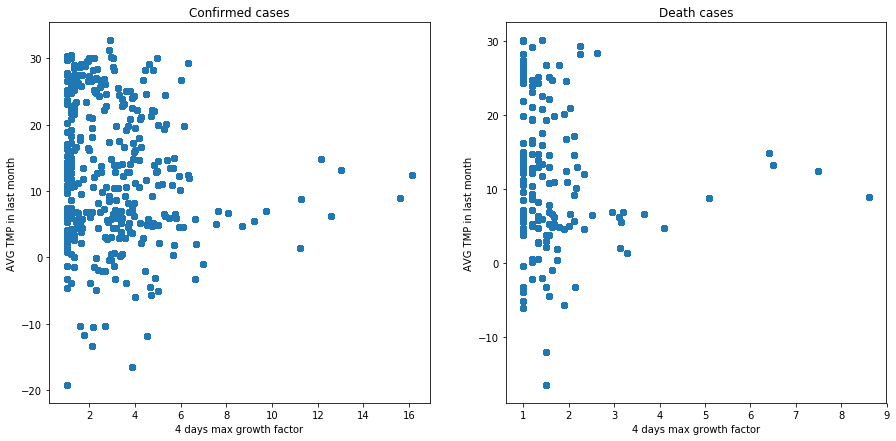

In [967]:
################################################################################
# CORRELATIONS AND SCATTER PLOTS AVG TMP VS GROWTH FACTOR CONFIRMED AND DEATHS #
################################################################################

TMP_RATE = 1
confs = conf_data[conf_data['Date'] == '3/22/2020'][conf_data['Cases'].astype(int) > 0]
deaths = death_data[death_data['Date'] == '3/22/2020'][death_data['max_cases'].astype(int) > 0]
confs['avg_m_tmp'] = confs['avg_m_tmp'] * TMP_RATE
deaths['avg_m_tmp'] = deaths['avg_m_tmp'] * TMP_RATE

conf_corrs_p = confs.corr().unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_p = conf_corrs_p[conf_corrs_p != 1]
_ = conf_corrs_p.drop_duplicates()
print('\nConfirmed cases growth_rate correaltion Pearson')
print(conf_corrs_p['growth_factor'])

conf_corrs_s = confs.corr('spearman').unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_s = conf_corrs_s[conf_corrs_s != 1]
_ = conf_corrs_s.drop_duplicates()
print('\nConfirmed cases growth_rate correaltion Spearman')
print(conf_corrs_s['growth_factor'])

death_corrs_p = deaths.corr().unstack().sort_values(kind="quicksort", ascending=False)
death_corrs_p = death_corrs_p[death_corrs_p != 1]
_ = death_corrs_p.drop_duplicates()
print('\nDeath cases growth_rate correaltion Pearson')
print(death_corrs_p['growth_factor'])

death_corrs_s = deaths.corr('spearman').unstack().sort_values(kind="quicksort", ascending=False)
death_corrs_s = death_corrs_s[death_corrs_s != 1]
_ = death_corrs_s.drop_duplicates()
print('\nDeath cases growth_rate correaltion Spearman')
print(death_corrs_s['growth_factor'])

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
_ = axes[0].scatter(conf_data[conf_data['growth_factor'].astype(int) > 0]['growth_factor'],\
                    conf_data[conf_data['growth_factor'].astype(int) > 0]['avg_m_tmp'])

_ = axes[1].scatter(death_data[death_data['growth_factor'].astype(int) > 0]['growth_factor'],\
                    death_data[death_data['growth_factor'].astype(int) > 0]['avg_m_tmp'])

_ = axes[0].set_xlabel('4 days max growth factor')
_ = axes[0].set_ylabel('AVG TMP in last month')
_ = axes[0].set_title('Confirmed cases')
_ = axes[1].set_xlabel('4 days max growth factor')
_ = axes[1].set_ylabel('AVG TMP in last month')
_ = axes[1].set_title('Death cases')